In [7]:
! pip install --quiet -U langgraph langchain_openai

In [56]:
from dotenv import load_dotenv
import os

_ = load_dotenv()

##os.environ['OPENAI_API_KEY']= XXXX
##os.environ['TAVILY_API_KEY']= XXXX
##os.environ['LANGCHAIN_API_KEY']= XXXX
##os.environ['LANGSMITH_TRACING_V2']= XXXX

In [57]:
from langgraph.graph import StateGraph, END

In [58]:
from langgraph.prebuilt import ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]
tool_node = ToolNode(tools)

In [82]:
from langchain_core.utils.function_calling import convert_to_openai_function
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True)
functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_tools(tools)


## Human-in-the-loop 

A human-in-the-loop workflow is used to involve human judgment into automated processes at specific moments that enable decision-making, validation, or corrections. This approach is  useful in applications utilizing large language models (LLMs), which may occasionally make mistakes or involve mission-critical decisions. In critical areas such as compliance, decision-making, or content creation, human oversight ensures accuracy by allowing for the review, correction, or overriding of the model's outputs.

The top 3 usecases to integrate this workflow in your agentic workflow include:
1. Approve

### Approve or Reject State

In [62]:
from typing import TypedDict, Annotated, Sequence, Literal
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


In [63]:
system_prompt = """
You are a helpful research agent. Your task is to make a quick search about a topic and write a small paragraph about the 
topic. If there is any feedback from the user you must also take it into consideration.
"""

In [64]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "review"

def call_model(state):
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

def interrupt_human_review(state)-> Command[Literal['rejected', "approved"]]:

    messages = state["messages"]
    last_message = messages[-1]
    human_review = interrupt(
        {
            "question": "Is this good?",
            "draft": last_message
        }
    )
    
    if human_review["feedback"]:
        return Command(goto='rejected')
    else:
        return Command(goto='approved')

def approve(state):
    return {**state, "messages": [{"role": "human", "content": "approved"}]}

def reject(state):
    return {**state,  "messages": [{"role": "human", "content": "rejected"}]}

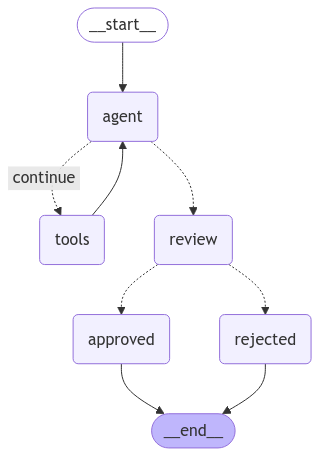

In [65]:
memory = MemorySaver()
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("review", interrupt_human_review)
workflow.add_node("approved", approve)
workflow.add_node("rejected", reject)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"tools",
        "review": "review"
    }
)

workflow.add_edge("tools", "agent")
workflow.add_edge("approved", END)
workflow.add_edge("rejected", END)



app = workflow.compile(checkpointer=memory)
app

In [66]:
from langchain_core.messages import HumanMessage

thread_config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [HumanMessage(content="What is the diifference between langchain and langgraph?")]}
result = app.invoke(inputs, thread_config)
print(result['messages'][-1].content)


Langchain is a framework for developing applications powered by large language models (LLMs). It consists of chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangSmith is a developer platform within Langchain that allows debugging, testing, evaluating, and monitoring chains built on any LLM framework. On the other hand, LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create agent and multi-agent workflows, enabling the creation of tool-calling agents and defining workflows within the graph structure. LangGraph integrates smoothly with LangChain but can also be used independently.


In [26]:
feedback = input("Is there any feedback?")
result = app.invoke(
        Command(resume={"feedback": feedback}),
    config=thread_config
    )
print(result['messages'][-1]["content"])

Is there any feedback? 


'approved'

### Review and Edit State


In [87]:
from typing import TypedDict, Annotated, Sequence, Literal
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
system_prompt = """
You are a helpful research agent. Your task is to make a quick search about a topic and write a small paragraph about the 
topic. If there is any feedback from the user you must also take it into consideration.
"""

In [111]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "review"

def call_model(state):
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

def interrupt_human_review(state):
    messages = state["messages"]
    last_message = messages[-1]
    human_review = interrupt(
        {
            "question": "Is this good?",
            "draft": last_message.content
        }
    )
    if human_review["edited_text"]:
        return {"messages": [HumanMessage(content=human_review["edited_text"])]}
    else:
        return {}
        


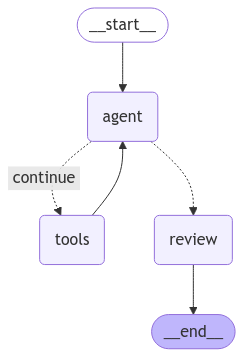

In [112]:
memory = MemorySaver()
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("review", interrupt_human_review)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"tools",
        "review": "review"
    }
)

workflow.add_edge("tools", "agent")
workflow.add_edge("review", END)

app = workflow.compile(checkpointer=memory)
app

In [113]:
from langchain_core.messages import HumanMessage

thread_config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [HumanMessage(content="What is the difference between langchain and langgraph")], "retries": 0}
result = app.invoke(inputs, thread_config)
print(result['messages'][-1].content)


LangChain is a framework for developing applications powered by large language models (LLMs). It consists of chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangSmith is a developer platform within LangChain that allows debugging, testing, evaluating, and monitoring chains built on any LLM framework. On the other hand, LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create agent and multi-agent workflows, enabling the creation of tool-calling agents and defining the flow of actions within the application. LangGraph integrates smoothly with LangChain but can also be used independently.


In [114]:
state = app.get_state(thread_config)

In [132]:
if state.tasks[0].interrupts:
    print(state.tasks[0].interrupts[0].value)

feedback = input("are there any edits?")
result = app.invoke(
        Command(resume={"edited_text": feedback}),
    config=thread_config
    )

{'question': 'Is this good?', 'draft': "LangChain is a framework for developing applications powered by large language models (LLMs). It consists of chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangSmith is a developer platform within LangChain that allows debugging, testing, evaluating, and monitoring chains built on any LLM framework. On the other hand, LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create agent and multi-agent workflows, enabling the creation of tool-calling agents and defining the flow of actions within the application. LangGraph integrates smoothly with LangChain but can also be used independently."}


are there any edits? LangChain is a framework for developing applications powered by large language models (LLMs). It consists of chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangSmith is a developer platform within LangChain that allows debugging, testing, evaluating, and monitoring chains built on any LLM framework. On the other hand, LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create agent and multi-agent workflows, enabling the creation of tool-calling agents and defining the flow of actions within the application. LangGraph integrates smoothly with LangChain but can also be used independently. Langchain is nice to use


In [133]:
print(result['messages'][-1].content)


LangChain is a framework for developing applications powered by large language models (LLMs). It consists of chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangSmith is a developer platform within LangChain that allows debugging, testing, evaluating, and monitoring chains built on any LLM framework. On the other hand, LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create agent and multi-agent workflows, enabling the creation of tool-calling agents and defining the flow of actions within the application. LangGraph integrates smoothly with LangChain but can also be used independently. Langchain is nice to use


### Multi Turn Conversation

In [84]:
from typing import TypedDict, Annotated, Sequence, Literal
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    retries: int = 0

In [28]:
system_prompt = """
You are a helpful research agent. Your task is to make a quick search about a topic and write a small paragraph about the 
topic. If there is any feedback from the user you must also take it into consideration.
"""

In [29]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "review"

def call_model(state):
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

def interrupt_human_review(state)-> Command[Literal[END, "agent"]]:
    if state["retries"] > 3:
        return Command(goto=END)
        
    messages = state["messages"]
    last_message = messages[-1]
    human_review = interrupt(
        {
            "question": "Is this good?",
            "draft": last_message
        }
    )
    if human_review["feedback"]:
        goto = "agent"
    else:
        return Command(goto=END)
        
    return Command(goto=goto, update={"retries": state.get("retries", 0)+1, "messages": [HumanMessage(content=human_review["feedback"], name="writer")]
})


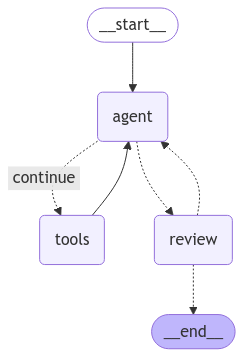

In [30]:
memory = MemorySaver()
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("review", interrupt_human_review)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"tools",
        "review": "review"
    }
)

workflow.add_edge("tools", "agent")

app = workflow.compile(checkpointer=memory)
app

In [31]:
from langchain_core.messages import HumanMessage

thread_config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [HumanMessage(content="What is the difference between langchain and langgraph")], "retries": 0}
result = app.invoke(inputs, thread_config)
print(result['messages'][-1].content)


LangChain is a framework for developing applications powered by large language models (LLMs). It consists of chains, agents, and retrieval strategies that make up an application's cognitive architecture. LangSmith is a developer platform within LangChain that allows debugging, testing, evaluating, and monitoring chains built on any LLM framework. On the other hand, LangGraph is a library for building stateful, multi-actor applications with LLMs. It is used to create agent and multi-agent workflows, enabling the creation of tool-calling agents and defining the flow of actions within the application. LangGraph integrates smoothly with LangChain but can also be used independently.


In [33]:
thread_config = {"configurable": {"thread_id": "1"}}

while True:
    feedback = input("Is there any feedback?")
    result = app.invoke(
            Command(resume={"feedback": feedback}),
        config=thread_config
        )
    print("\n {}".format(result['messages'][-1].content))
    if not feedback:
        break

from IPython.display import display, Markdown, Latex
display(Markdown(result['messages'][-1].content))
        

Is there any feedback? Can I use it with crewai?


LangChain and LangGraph can be used independently or in conjunction with other tools and frameworks like CrewAI. CrewAI is a platform that provides AI-powered writing assistance, and while it may not have a direct integration with LangChain or LangGraph, you can potentially leverage the capabilities of these frameworks alongside CrewAI to enhance the functionality and performance of your writing applications. Integrating different AI tools and frameworks can often lead to more robust and comprehensive solutions, so exploring the compatibility and synergy between CrewAI and LangChain/LangGraph could be beneficial for your writing projects.


Is there any feedback? can you add about Autogen?


Autogen is a powerful AI writing tool that can be used in conjunction with frameworks like LangChain and LangGraph to enhance the writing process further. Autogen utilizes advanced natural language processing (NLP) algorithms to generate high-quality content, making it a valuable addition to writing applications. By integrating Autogen with LangChain and LangGraph, users can benefit from a comprehensive set of tools for developing context-aware reasoning applications, building stateful multi-actor workflows, and generating AI-powered content efficiently. The combination of Autogen with these frameworks can offer a holistic approach to writing tasks, enabling users to create engaging and informative content with ease.


Is there any feedback? So is autogen better than crewai with langchain and langgraph explain in detail.


Autogen and CrewAI are both powerful AI writing tools that offer unique features and capabilities. When comparing Autogen with CrewAI in conjunction with LangChain and LangGraph, several factors come into play:

1. **Autogen's Strengths**:
   - Autogen is known for its advanced natural language processing (NLP) algorithms that can generate high-quality content efficiently.
   - It offers a wide range of writing assistance features, including content generation, language correction, and style improvement.
   - Autogen's focus on content creation and generation makes it a valuable tool for users looking to automate the writing process and produce large volumes of text.

2. **CrewAI's Strengths**:
   - CrewAI is a platform specifically designed for AI-powered writing assistance, offering features like grammar checking, plagiarism detection, and readability analysis.
   - It provides a user-friendly interface and a seamless writing experience, making it popular among writers and content cr

Is there any feedback? 


Autogen and CrewAI are both powerful AI writing tools that offer unique features and capabilities. When comparing Autogen with CrewAI in conjunction with LangChain and LangGraph, several factors come into play:

1. **Autogen's Strengths**:
   - Autogen is known for its advanced natural language processing (NLP) algorithms that can generate high-quality content efficiently.
   - It offers a wide range of writing assistance features, including content generation, language correction, and style improvement.
   - Autogen's focus on content creation and generation makes it a valuable tool for users looking to automate the writing process and produce large volumes of text.

2. **CrewAI's Strengths**:
   - CrewAI is a platform specifically designed for AI-powered writing assistance, offering features like grammar checking, plagiarism detection, and readability analysis.
   - It provides a user-friendly interface and a seamless writing experience, making it popular among writers and content cr

'Canada has announced a $155 billion tariff package in response to unjustified and unreasonable tariffs imposed by the United States on Canadian goods. The Government of Canada is moving forward with 25% tariffs on $155 billion worth of goods as a retaliatory measure. Additionally, there are tariff classifications for goods imported into Canada, showing preferential tariffs for products from countries with which Canada has free trade agreements. The list of products from the United States subject to 25% tariffs effective February 4, 2025, is available for reference.'

### Tool Execution

In [36]:
from typing import TypedDict, Annotated, Sequence, Literal
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]



In [182]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "end"

def call_model(state):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

def interrupt_human_review(state)-> Command[Literal[END, "tools"]]:
    messages = state["messages"]
    last_message = messages[-1]
    human_review = interrupt(
        {
            "question": "Is this correct",
            "tool_call": last_message.tool_calls
        }
    )
    
    if human_review["continue"]=="yes":
        return Command(goto="tools")
    else:
        return Command(goto=END)
    

    


In [183]:

memory = MemorySaver()
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("review", interrupt_human_review)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"review",
        "end": END
    }
)

workflow.add_edge("tools", "agent")

app = workflow.compile(checkpointer=memory)

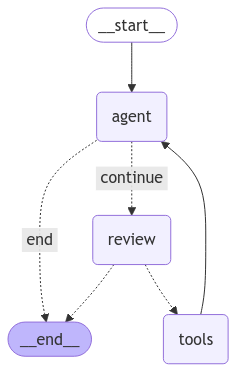

In [184]:
app

In [54]:
from langchain_core.messages import HumanMessage

thread_config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [HumanMessage(content="who is the current. PM of canada?")]}
result = app.invoke(inputs, thread_config)
print(result['messages'][-1].tool_calls)

[{'name': 'tavily_search_results_json', 'args': {'query': 'current Prime Minister of Canada'}, 'id': 'call_rk4WgClx32HBYyR8rQvGVE61', 'type': 'tool_call'}]


In [55]:
continue_result = input("Should I continue with the tool call?")
result = app.invoke(
        Command(resume={"continue": continue_result}),
    config=thread_config
)
from IPython.display import display, Markdown, Latex
display(Markdown(result['messages'][-1].content))

Should I continue with the tool call? yes


The current Prime Minister of Canada is Justin Trudeau. He is Canada's 23rd Prime Minister and was re-elected on September 20, 2021, earning a third mandate to govern from Canadians. You can find more information about him on the [official website](https://www.pm.gc.ca/en/about).

### Validating Human Input 

In [176]:
from typing import TypedDict, Annotated, Sequence, Literal
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


In [185]:
system_prompt = """
You are a helpful research agent. Your task is to make retrieve population. If user specifies an year use that otherwise use 2025.
"""

In [230]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "continue"
    return "review"

def call_model(state):
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}
    
def interrupt_human_review(state)-> Command[Literal[END, "agent"]]:
    question = "Please specify any year for pupulation otherwise leave it empty"
    while True:
        answer = interrupt(question)
        if answer:
            
            # Validate answer, if the answer isn't valid ask for input again.
            if not isinstance(answer, int) or answer < 0:
                print("I am here")
                question = f"'{answer} is not a valid year. Please specify year?"
                answer = None
                continue
            else:
                return Command(goto='agent', update={
                "messages": [HumanMessage(content="Try again for the year {}".format(answer))]
                })
        else:
            return Command(goto=END)
        
        

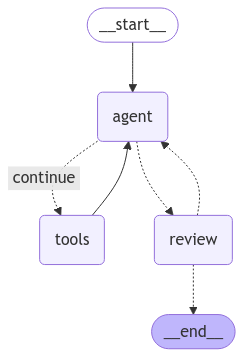

In [231]:
memory = MemorySaver()
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("review", interrupt_human_review)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue":"tools",
        "review": "review"
    }
)

workflow.add_edge("tools", "agent")

app = workflow.compile(checkpointer=memory)
app

In [232]:
from langchain_core.messages import HumanMessage

thread_config = {"configurable": {"thread_id": "1"}}

inputs = {"messages": [HumanMessage(content="For Canada")]}
result = app.invoke(inputs, thread_config)


In [233]:
print(result['messages'][-1])

content='The current population of Canada in 2025 is approximately 39,431,447, with a 0.83% increase from 2024. Additionally, the current population of Canada is approximately 39,978,188 as of February 11, 2025.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'} id='run-3b705e47-18ef-46de-b4c2-1615a74ba7e0-0'


In [234]:
state = app.get_state(thread_config)

In [235]:
print(state.tasks[0].interrupts[0].value)
result = app.invoke(
        Command(resume="twenty"),
    config=thread_config
    )

Please specify any year for pupulation otherwise leave it empty
I am here


In [237]:
state = app.get_state(thread_config)
state.tasks[0].interrupts[0].value

"'twenty is not a valid year. Please specify year?"

In [238]:
result = app.invoke(
        Command(resume=2021),
    config=thread_config
    )

'twenty is not a valid year. Please specify year?
I am here


In [239]:
print(result['messages'][-1])

content='The population of Canada in 2021 was 36,991,981. As of February 11, 2025, the current population of Canada is approximately 39,978,188.' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'} id='run-3e2a7013-4c2b-4604-a940-577c6d737ade-0'
